In [1]:
import yaml
from pathlib import Path

import torch
from resemblyzer import VoiceEncoder, preprocess_wav
import numpy as np
from librosa.feature import melspectrogram

from common.model_loader import get_model
from common.feature_extraction import LogMelFeatureExtractor


# path to folder with checkpoint.pth
CHECKPOINT_PATH = Path("../models/pretrained/100h/PVAD1_SC_DenoisingAPC_finetune_100h_noisy/PVAD1_SC_DenoisingAPC_finetune_100h_noisy_99460/best.pt").resolve()

# Features extractor
feature_config = {'sample_rate': 16000,
                  'n_mels': 40,
                  'n_fft': 400,
                  'window_length': 400,
                  'hop_length': 160}
feature_extractor = LogMelFeatureExtractor(**feature_config)

# test device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get model config
yaml.add_multi_constructor('tag:yaml.org,2002:python/object/apply:torch.device',
                            lambda loader, suffix, node: None)
with open(str(CHECKPOINT_PATH.parent / "settings.txt"), "r", encoding="utf8") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
model_config = config["hparams"]["model"]["encoder"]

# Load model architecture and pretrained weights
def load_pretrained_model(model: torch.nn.Module, checkpoint_path: str = "", map_location: str = "cpu"):
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    model_state_dict = model.state_dict()
    checkpoint_model_state_dict = checkpoint["model_state_dict"]
    model_state_dict.update(checkpoint_model_state_dict)
    model.load_state_dict(model_state_dict)
    print(f"Loaded checkpoint {checkpoint_path}.")
    return model
model = get_model(model_config)
model = load_pretrained_model(model, checkpoint_path=str(CHECKPOINT_PATH), map_location="cpu")
model = model.to(device)

Loaded checkpoint /Users/JG96XG/PycharmProjects/SelfSupervisedPVAD/models/pretrained/100h/PVAD1_SC_DenoisingAPC_finetune_100h_noisy/PVAD1_SC_DenoisingAPC_finetune_100h_noisy_99460/best.pt.


In [49]:
speaker_encoder = VoiceEncoder(device="cpu") # For speaker similarity

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def compute_similarity(waveform, speaker_embedding, speaker_encoder):
    rate = 2.5
    min_coverage = 0.5
    waveform_copy = waveform[0].numpy().copy()
    wav_slices, mel_slices = speaker_encoder.compute_partial_slices(waveform_copy.size,
                                                                    rate=rate,
                                                                    min_coverage=min_coverage)
    max_wave_length = wav_slices[-1].stop
    if max_wave_length >= waveform_copy.size:
        waveform_copy = np.pad(waveform_copy, (0, max_wave_length - waveform_copy.size), "constant")
    features = melspectrogram(y=waveform_copy, sr=16000, n_fft=400, hop_length=160, n_mels=40).astype('float32').T
    features_sliced = np.array([features[s] for s in mel_slices])
    with torch.no_grad():
        embedding_slices = speaker_encoder(torch.from_numpy(features_sliced)).numpy()

    scores_slices = np.array([cos_sim(speaker_embedding, partial_embedding) for partial_embedding in embedding_slices])

    # Scores, linearly interpolated, starting from 0.5 every time
    frame_step = int(np.round((16000 / rate) / 160))
    # First 160 frames are score one (160 frames window)
    scores_linear_interpolated = np.kron(scores_slices[0], np.ones(160, dtype='float32'))
    # The rest are linearly interpolated
    for i, s in enumerate(scores_slices[1:]):
        scores_linear_interpolated = np.append(scores_linear_interpolated,
                                               np.linspace(scores_slices[i], s, frame_step, endpoint=False))

    similarity = torch.from_numpy(scores_linear_interpolated)
    return similarity

Loaded the voice encoder model on cpu in 0.01 seconds.


In [82]:
# Example input
input_tensor = torch.randn(size=(1, 160000))
reference_tensor = torch.randn(size=(1, 160000))

# Compute speaker embedding of reference speech
waveform_preprocessed = preprocess_wav(reference_tensor[0].numpy())
speaker_embedding = torch.from_numpy(speaker_encoder.embed_speaker([waveform_preprocessed])).unsqueeze(0)

In [100]:
# Compute features
features = feature_extractor(input_tensor)
lengths = torch.tensor([features.size(-1)])

# Compute similarity vector
similarity = compute_similarity(input_tensor, speaker_embedding, speaker_encoder)[:features.size(-1)]

features = features.transpose(1, 2)
similarity = similarity.unsqueeze(0)

In [101]:
print(similarity.size())
print(features.size())

torch.Size([1, 1001])
torch.Size([1, 1001, 40])


In [106]:
# Put input through model
with torch.no_grad():
    outputs = model(x=features, x_lens=lengths, similarity_scores=similarity)

In [112]:
vad_scores = torch.nn.functional.softmax(outputs[0], dim=-1)

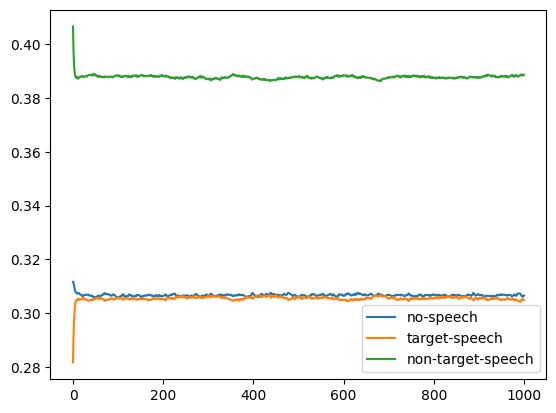

In [113]:
from matplotlib import pyplot as plt

plt.plot(vad_scores[0, :, 0], label="no-speech")
plt.plot(vad_scores[0, :, 1], label="target-speech")
plt.plot(vad_scores[0, :, 2], label="non-target-speech")
plt.legend()
plt.show()